In [1]:
%cd /content/drive/MyDrive/4조/2.데이터

/content/drive/.shortcut-targets-by-id/1t5JFoUpndxpFtZ957fKqxENUgFJ7lTNo/4조/2.데이터


In [2]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 5.0 MB/s 


In [3]:
import cv2, math, warnings
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
warnings.filterwarnings('ignore')

## 0.Media Pipe 적용

In [29]:
def find_point(image):    
    max_num_hands = 1

    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    drawing_spec = mp_drawing.DrawingSpec(thickness=50, circle_radius=20)

    hands = mp_hands.Hands(
        max_num_hands=max_num_hands,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5)

    cap = cv2.VideoCapture(0)
    img_copy = image.copy()
    result = hands.process(img_copy)

    if result.multi_hand_landmarks is not None:
        index = 1 - result.multi_handedness[0].classification[0].index
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 3))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            if len(joint) == 21:
                h, w, c = img_copy.shape
                point = joint * [w, h, c]

                # 관절의 각도를 계산하기 위한 vector
                v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
                v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
                v = v2 - v1 # [20,3]
                # Normalize v
                v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                # Get angle using arcos of dot product
                angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,] 

                angle = np.degrees(angle) # Convert radian to degree

                # Inference gesture
                data = np.array([angle], dtype=np.float32)
        
                mp_drawing.draw_landmarks(img_copy, res, mp_hands.HAND_CONNECTIONS, 
                                        mp_drawing.DrawingSpec(color=(112, 146, 190), thickness=20, circle_radius=10), 
                                        mp_drawing.DrawingSpec(color=(153, 217, 234), thickness=20, circle_radius=10))
                return img_copy, point, index
            
            else:
                print('손을 가운데에 위치시켜주세요.')
    
    else:
        print('손을 가운데에 위치시켜주세요.')
# 163,73,164 / 200,191,231

## 1.이미지 자르기
- A(손끝), B(첫 번째 관절), C(두 번째 관절), D(세 번째 관절)
- grad : 손가락의 기울기
- center  : A와 B의 중심
- dist  : A와 B 사이의 거리

In [14]:
# 각 손가락의 각도에 맞게 1자로 세우는 함수
def rotation_finger(img, point):
    plt.figure(figsize=(15, 6))
    for num, idx in enumerate(range(4,21,4)):
        A = point[idx]; B = point[idx-1]; D = point[idx-3]

        center = ((A[0]+B[0])/2, (A[1]+B[1])/2)             # 중심 좌표 계산
        dist = ((A[1]-B[1])**2 + (A[0]-B[0])**2)**(1/2)     # 피타고라스 정리
        rad = math.atan2(A[1] - D[1],A[0] - D[0] )
        degree = 90+(rad*180)/ math.pi

        # 이미지 회전
        img_copy = img.copy()
        matrix = cv2.getRotationMatrix2D(center, degree, scale=1)
        img_copy = cv2.warpAffine(img_copy, matrix, (img_copy.shape[1], img_copy.shape[0]))
        plt.subplot(2, 5, num+1);
        plt.axis('off')
        plt.imshow(img_copy)       


        # 자르기 영역
        pt_x1 = int(center[0] - dist*0.7)
        pt_y1 = int(center[1] - dist*1.5)
        pt_x2 = int(center[0] + dist*0.7)
        pt_y2 = int(center[1] + dist*0.8)
        
        if pt_x1 < 0 :
            pt_x1 = 0
        if pt_x2 > img.shape[0]:
            pt_x2 = img.shape[0]

        print(pt_y1, pt_y2, pt_x1, pt_x2)

        globals()['img{}'.format(num)] = img_copy[pt_y1:pt_y2, pt_x1:pt_x2]             # [y범위, x범위]
        print(globals()['img{}'.format(num)].shape)

        plt.subplot(2, 5, 5+num+1)
        plt.axis('off')
        plt.imshow(globals()['img{}'.format(num)]);

0


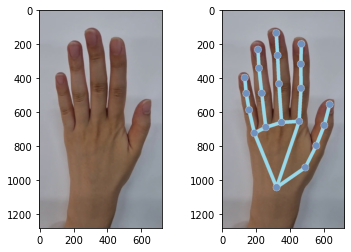

In [36]:
img_name = '손_300'
image = cv2.imread(f"./손이미지/{img_name}.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

try:
    img, point, index = find_point(image)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(img);
    print(index)
except:
    print('종료')

426 717 526 702
(291, 176, 3)
81 353 379 545
(272, 166, 3)
4 306 229 413
(302, 184, 3)
122 374 136 290
(252, 154, 3)
304 516 72 201
(212, 129, 3)


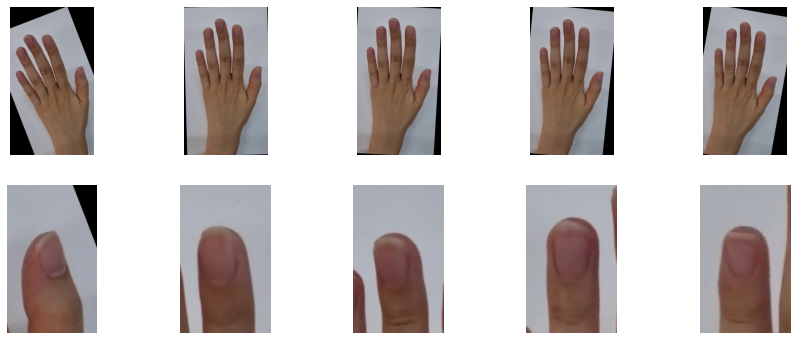

In [37]:
rotation_finger(image, point)

# 2.마스크 이미지

In [72]:
# 마스크 이미지를 원본 이미지의 좌표에 맞춰 회전, 자르기
def rotation_mask(mask, point, img = img1):
    plt.figure(figsize=(15, 6))
    div5 = int(img1.shape[1]//5)                           # 마스크의 x축 길이를 5로 나눈 값
    for num, idx in enumerate(range(4,21,4)):
        A = point[idx]; B = point[idx-1]; D = point[idx-3]

        center = ((A[0]+B[0])/2, (A[1]+B[1])/2)             # 중심 좌표 계산
        dist = ((A[1]-B[1])**2 + (A[0]-B[0])**2)**(1/2)     # 피타고라스 정리
        rad = math.atan2(A[1] - D[1],A[0] - D[0] )
        degree = 90+(rad*180)/ math.pi

        # 이미지 회전
        mask_copy = mask.copy()
        matrix = cv2.getRotationMatrix2D(center, degree, scale=1)
        mask_copy = cv2.warpAffine(mask_copy, matrix, (mask_copy.shape[1], mask_copy.shape[0]))
        plt.subplot(2, 5, num+1);
        plt.axis('off')
        plt.imshow(mask_copy)       


        # 자르기 영역
        pt_x1 = int(center[0] - dist*0.7)
        pt_y1 = int(center[1] - dist*1.5)
        pt_x2 = int(center[0] + dist*0.7)
        pt_y2 = int(center[1] + dist*0.8)
        
        if pt_x1 < 0 :
            pt_x1 = 0
        if pt_x2 > mask.shape[0]:
            pt_x2 = mask.shape[0]

        print(pt_y1, pt_y2, pt_x1, pt_x2)

        globals()['mask{}'.format(num)] = mask_copy[pt_y1:pt_y2, pt_x1:pt_x2]             # [y범위, x범위]
        print(globals()['mask{}'.format(num)].shape)

        # 손톱 이외의 영역 지우기
        for row in globals()['mask{}'.format(num)]:
            row[:div5] = 0
            row[div5*4:] = 0

        plt.subplot(2, 5, 5+num+1)
        plt.axis('off')
        plt.imshow(globals()['mask{}'.format(num)]);

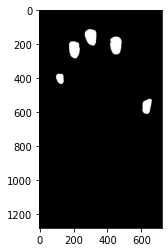

In [38]:
mask = cv2.imread(f'./손톱마스크/{img_name}.jpg')
plt.imshow(mask);

426 717 526 702
(291, 176, 3)
81 353 379 545
(272, 166, 3)
4 306 229 413
(302, 184, 3)
122 374 136 290
(252, 154, 3)
304 516 72 201
(212, 129, 3)


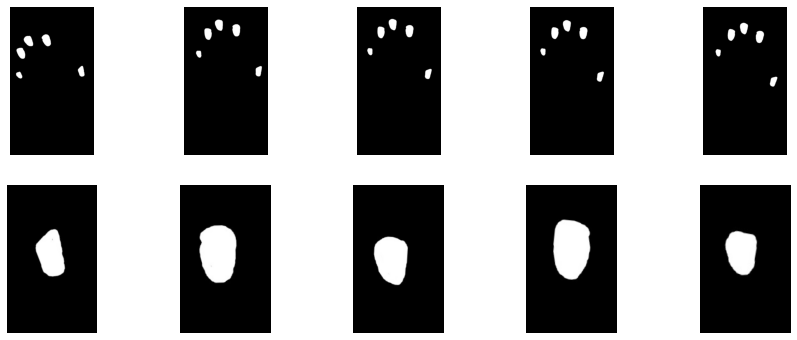

In [73]:
rotation_mask(mask,point)

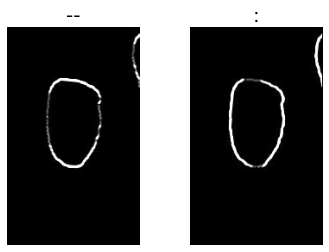

In [51]:
# 수직/수평 마스크
for k in [1, 0]:
    sobel = cv2.Sobel(mask3, cv2.CV_64F, k, 1-k, ksize = 3)
    sobel = cv2.convertScaleAbs(sobel)
    if k == 1:
        name = ':'
    else:
        name='--'
    plt.subplot(1, 2, k+1)
    plt.title(f'{name}', fontsize = 20)
    plt.axis('off')
    plt.imshow(sobel);

In [109]:
# 손톱 영역 좌표
np.where(mask0 > 250)[0][-1]
y0 = np.where(mask0 > 250)[0].min()
y1 = np.where(mask0 > 250)[0].max()
x0 = np.where(mask0 > 250)[1].min()
x1 = np.where(mask0 > 250)[1].max()

# 손톱 가로 길이, 세로 길이
width = x1 - x0; vertical = y1-y0
print(width, vertical)

54 90


# 3.손톱디자인

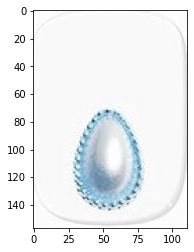

In [75]:
nail = cv2.imread('/content/손톱디자인1-0.jpg')
plt.imshow(nail, cmap = 'gray')

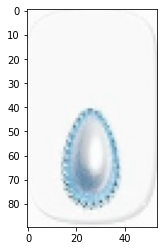

In [119]:
# 손톱 이미지를 손톱 크기만큼 줄이기
nail_resize = cv2.resize(nail, (width, vertical))
plt.imshow(nail_resize, cmap = 'gray');

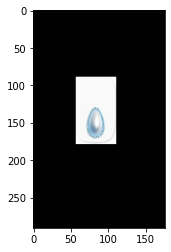

In [140]:
nail_exp = np.ones_like(mask0)
nail_exp[y0:y1, x0:x1] = nail_resize
plt.imshow(nail_exp.astype(np.uint8), cmap='gray');

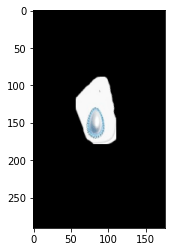

In [141]:
nail_mask0 = cv2.bitwise_and(nail_exp, mask0)
plt.imshow(nail_mask0, cmap='gray');

60 99


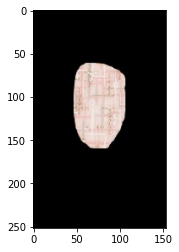

In [144]:
# 손톱 영역 좌표
np.where(mask3 > 250)[0][-1]
y0 = np.where(mask3 > 250)[0].min()
y1 = np.where(mask3 > 250)[0].max()
x0 = np.where(mask3 > 250)[1].min()
x1 = np.where(mask3 > 250)[1].max()

# 손톱 가로 길이, 세로 길이
width = x1 - x0; vertical = y1-y0
print(width, vertical)

nail3 = cv2.imread('/content/손톱디자인1-4.jpg')
nail3 = cv2.cvtColor(nail3, cv2.COLOR_BGR2RGB)
nail_resize3 = cv2.resize(nail3, (width, vertical))
nail_exp3 = np.ones_like(mask3)
nail_exp3[y0:y1, x0:x1] = nail_resize3
nail_mask3 = cv2.bitwise_and(nail_exp3, mask3)
plt.imshow(nail_mask3, cmap='gray');

#4.쉐입에 디자인 입히기

In [152]:
x1 - x0, sh_x1-sh_x0

(60, 61)

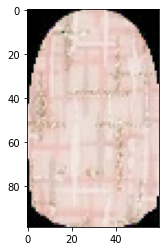

In [155]:
sh = cv2.imread('/content/네일쉐입_라운디드_4.jpg')
sh_y0 = np.where(sh>250)[0].min()
sh_y1 = np.where(sh>250)[0].max()
sh_x0 = np.where(sh>250)[1].min()
sh_x1 = np.where(sh>250)[1].max()

sh = sh[sh_y0:sh_y1, sh_x0:sh_x1]
sh = cv2.resize(sh, (width, vertical))
nail_shape3 = cv2.bitwise_and(nail_resize3, sh)
plt.imshow(nail_shape3);

In [157]:
nail_shape3.shape[0]

99

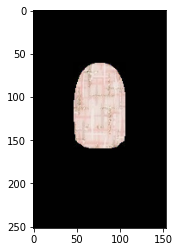

In [158]:
nail_exp3 = np.ones_like(mask3)
nail_exp3[y0:y0+nail_shape3.shape[0], x0:x1] = nail_shape3
plt.imshow(nail_exp3);